# Segmentation Mask to Network

Topological Data Analysis (TDA) in bioimage is often performed on cell positions and carrying multiomics information. The spatial analysis, therefore, would be suitable to be represented in graph networks. Similar analogy can be performed on WSI collagen data for spatial distributions through the tissue.

Here we demonstrate the workflow for label mask and morphological feature embedding to a graph network to simplify the data complexity of large label masks.

In [1]:
import os
import tifffile

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np

import networkx as nx
from skimage import measure


## Data Loading

In [2]:
IMG_PATH = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Human/21P00655-A7-025-M-Adv-PSR/PSR.ome.tiff"
LABEL_PATH = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Human/21P00655-A7-025-M-Adv-PSR/collagen.ome.tiff"

OUTPUT_DIR = "/media/Data3/Jacky/Data/Dafni_lung_slide_scans/Human/21P00655-A7-025-M-Adv-PSR"

In [3]:
image = tifffile.imread(IMG_PATH)
label = tifffile.imread(LABEL_PATH)

In [4]:
SUBREGION=[image.shape[0]//2-1024//2,image.shape[1]//2-1024//2,1024,1024]

In [5]:
image_crop = image[SUBREGION[1]:SUBREGION[1]+SUBREGION[3],SUBREGION[0]:SUBREGION[0]+SUBREGION[2]]
label_crop = label[SUBREGION[1]:SUBREGION[1]+SUBREGION[3],SUBREGION[0]:SUBREGION[0]+SUBREGION[2]]

Text(0.5, 1.0, 'Overlay')

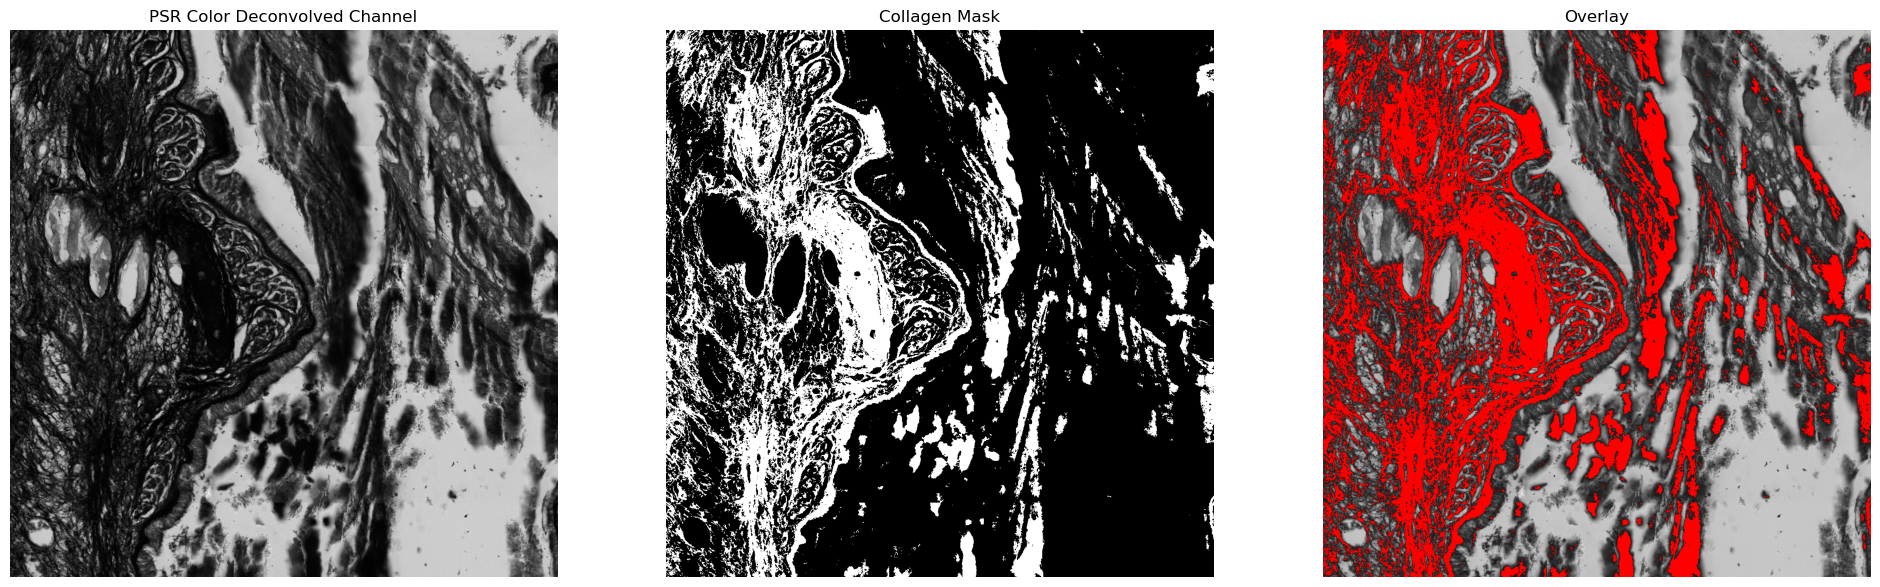

In [6]:
fig, axs = plt.subplots(1,3,figsize=(24,8))

axs[0].imshow(image_crop,cmap="gray")
axs[0].set_axis_off()
axs[0].set_title("PSR Color Deconvolved Channel")

axs[1].imshow(label_crop,cmap="gray")
axs[1].set_axis_off()
axs[1].set_title("Collagen Mask")

image_overlay_ = np.stack([image_crop]*3,axis=-1)
image_overlay_[label_crop>0] = [255,0,0]

axs[2].imshow(image_overlay_)
axs[2].set_axis_off()
axs[2].set_title("Overlay")

## Skeletonize the Mask

In [7]:
# relabel the mask
label_crop_re = measure.label(label_crop, connectivity=2) 

In [8]:
# Extract region properties, including area
regions = measure.regionprops(label_crop_re)

In [30]:
# Create a NetworkX graph
G = nx.Graph()

# Set a distance threshold
distance_threshold = 20

# Add nodes with region information
for region in regions[::2]:
    centroid = region.centroid
    G.add_node(region.label, 
               area=region.area, 
               pos=(centroid[1],centroid[0]),
               perimeter=region.perimeter, 
               eccentricity=region.eccentricity,
               )
    
# Compute distances and add edges based on the threshold
for u in G.nodes():
    for v in G.nodes():
        if u != v:
            dist = np.linalg.norm(np.array(G.nodes[u]["pos"]) - np.array(G.nodes[v]["pos"]))
            if dist > 0 and dist <=distance_threshold:
                G.add_edge(u, v,dist=dist)

In [15]:
# Extract node positions and area information from the graph
node_positions = {node: G.nodes[node]['pos'] for node in G.nodes}
node_areas = {node: G.nodes[node]['area'] for node in G.nodes}
node_perimeters = {node: G.nodes[node]['perimeter'] for node in G.nodes}
node_eccentricities = {node: G.nodes[node]['eccentricity'] for node in G.nodes}

# Normalize values for coloring
norm_area = plt.Normalize(np.percentile(list(node_areas.values()),15), np.percentile(list(node_areas.values()),85))
norm_perimeter = plt.Normalize(np.percentile(list(node_perimeters.values()),15), np.percentile(list(node_perimeters.values()),85))
norm_eccentricity = plt.Normalize(np.percentile(list(node_eccentricities.values()),15), np.percentile(list(node_eccentricities.values()),85))
cmap = plt.get_cmap('viridis')

# Draw nodes with colors based on area
sm_area = ScalarMappable(cmap=cmap, norm=norm_area)
sm_area.set_array([])  # An empty array is required for the ScalarMappable

(1.0, 1023.0)

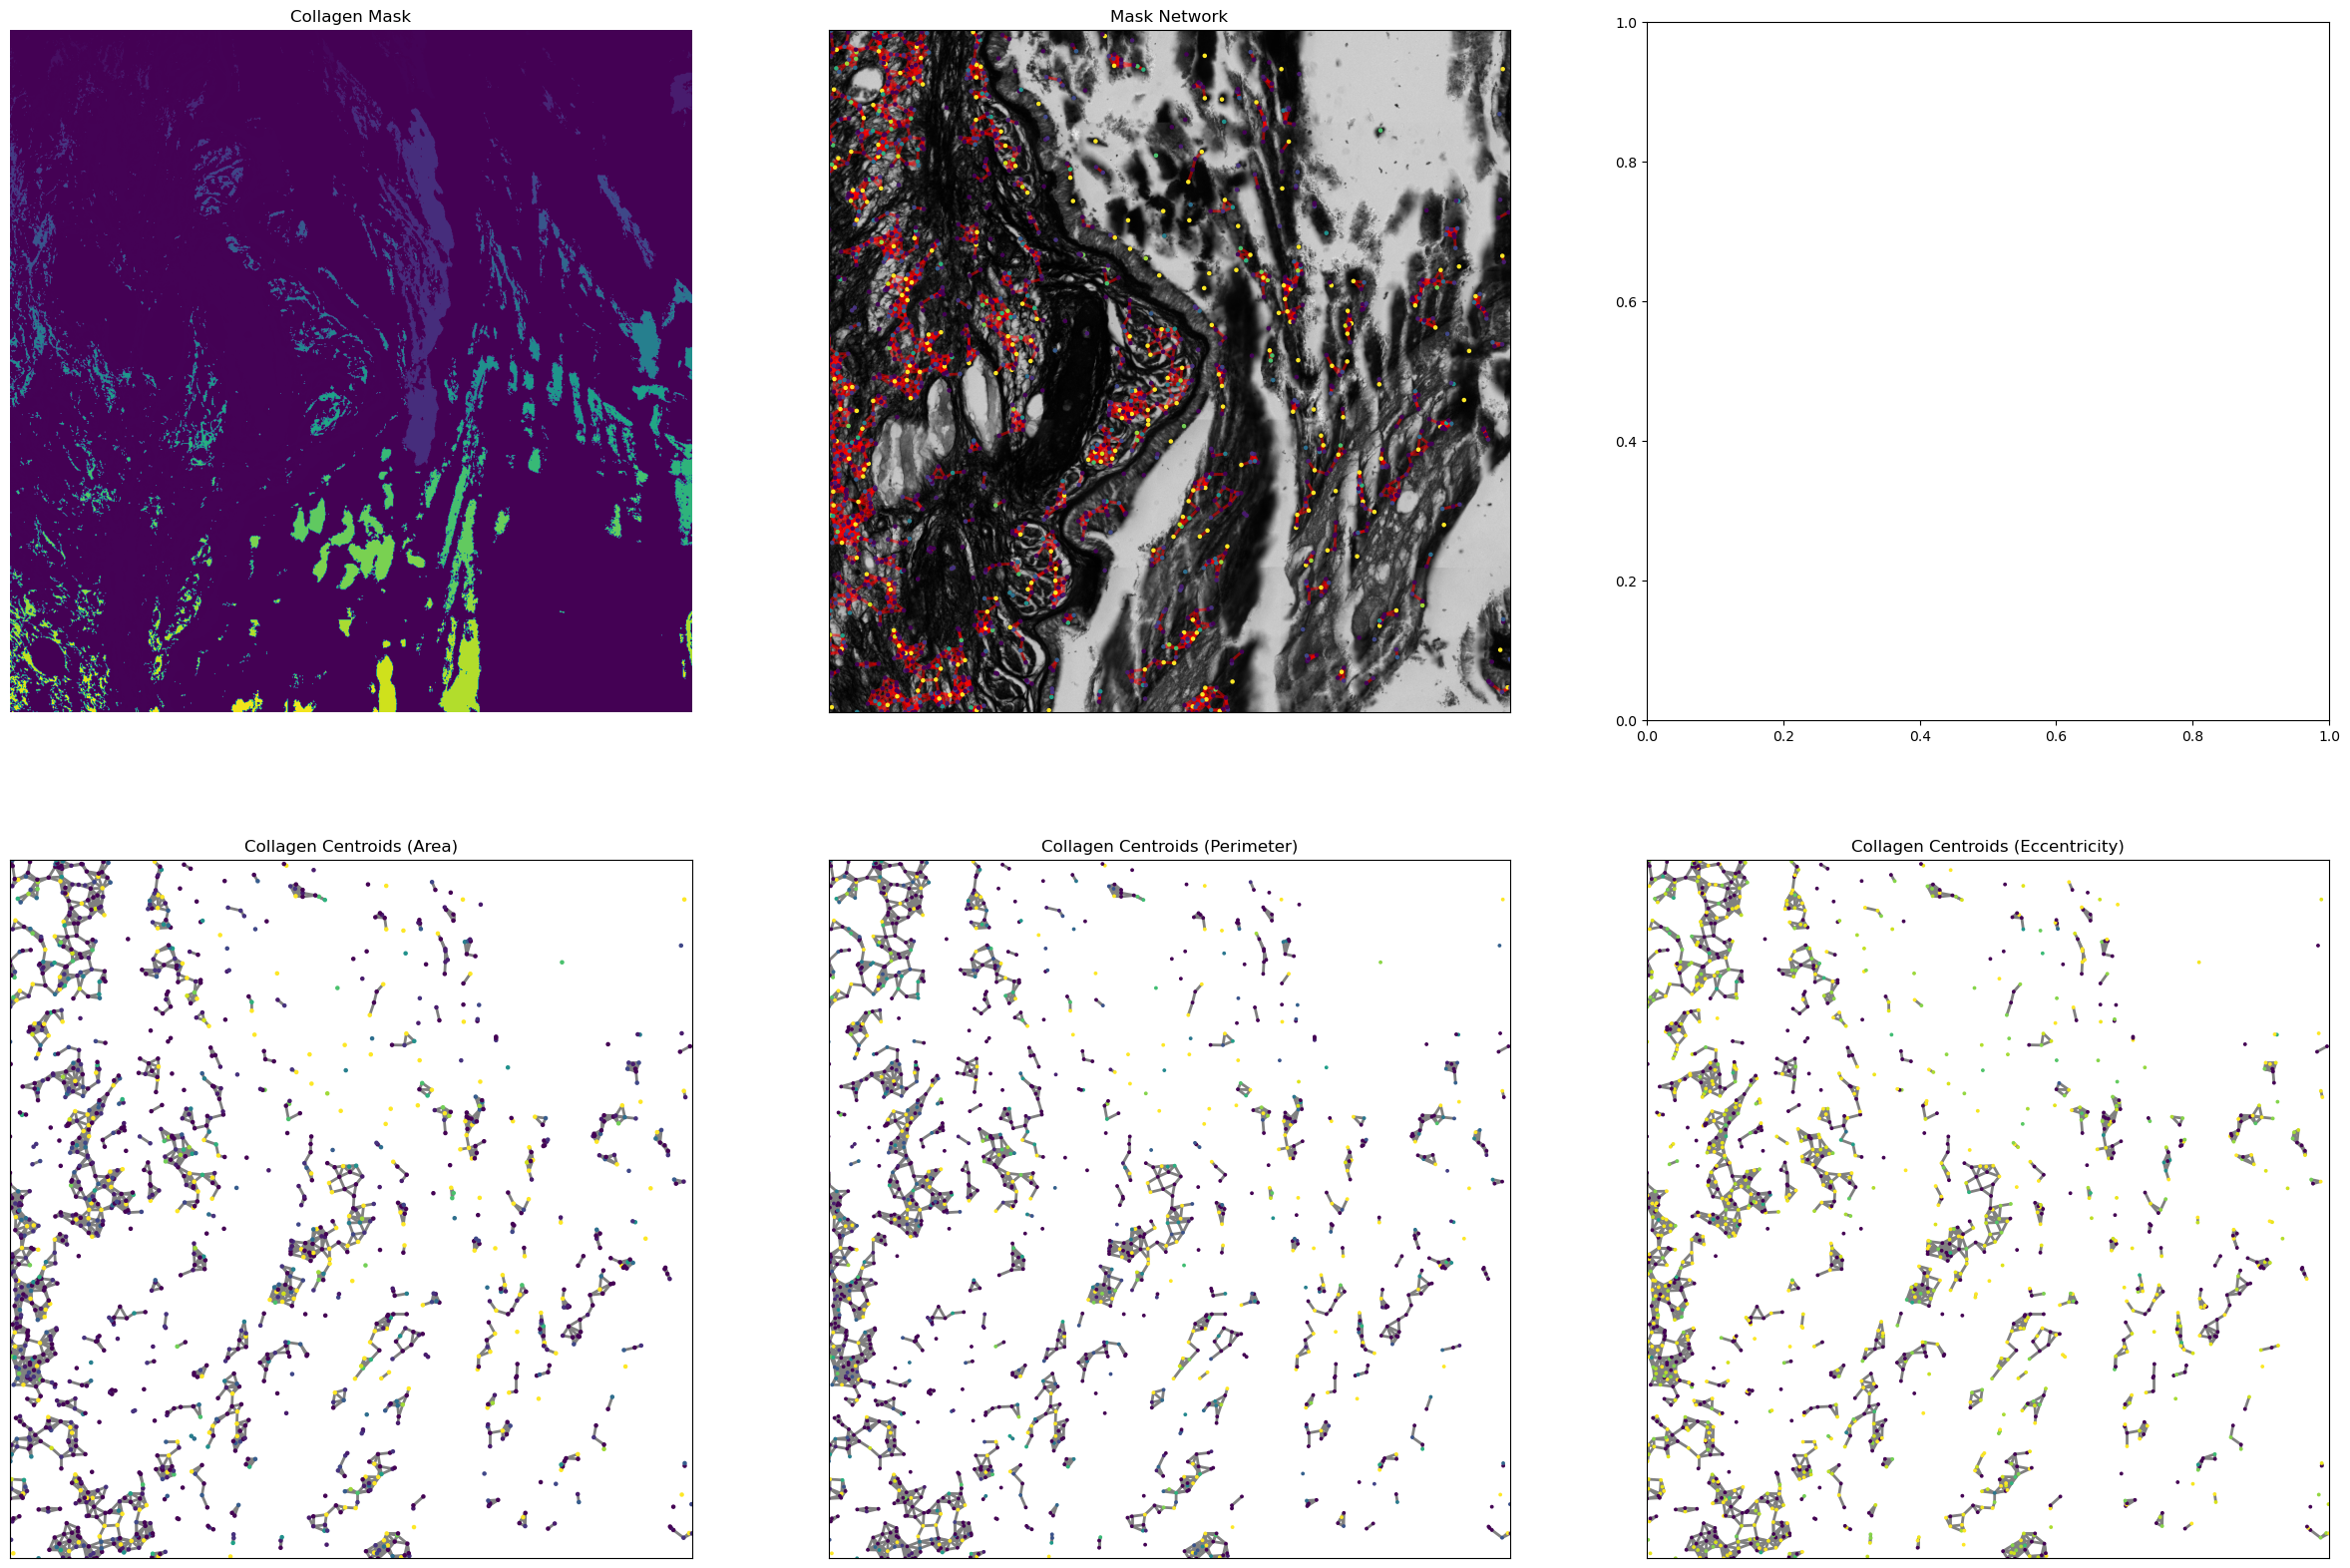

In [33]:
fig, axs = plt.subplots(2,3,figsize=(30,20))
axs = axs.ravel()

axs[0].imshow(label_crop_re,cmap="viridis")
axs[0].set_axis_off()
axs[0].set_title("Collagen Mask")

axs[1].imshow(image_crop,cmap="gray")
axs[1].set_title("Mask Network")
pos = nx.spring_layout(G)  # You can choose different layout algorithms
node_colors = [cmap(norm_area(node_areas[node])) for node in G.nodes]

# Draw nodes with centroids as positions
nx.draw_networkx_nodes(G, pos=node_positions, node_size=5, node_color=node_colors, ax=axs[1])
nx.draw_networkx_edges(G, pos=node_positions, edge_color='red', alpha=0.5, width=2, ax=axs[1])
axs[1].set_xlim([0,image_crop.shape[0]-1])
axs[1].set_ylim([1,image_crop.shape[1]-1])

axs[3].set_title("Collagen Centroids (Area)")
pos = nx.spring_layout(G)  # You can choose different layout algorithms
node_colors = [cmap(norm_area(node_areas[node])) for node in G.nodes]
# Extract node positions from the 'pos' attribute in the graph
node_positions = {node: G.nodes[node]['pos'] for node in G.nodes}

# Draw nodes with centroids as positions
nx.draw_networkx_nodes(G, pos=node_positions, node_size=5, node_color=node_colors, ax=axs[3])
nx.draw_networkx_edges(G, pos=node_positions, edge_color='gray', alpha=1.0, width=2, ax=axs[3])
axs[3].set_xlim([0,image_crop.shape[0]-1])
axs[3].set_ylim([1,image_crop.shape[1]-1])

# # Add colorbar
# cbar = plt.colorbar(sm_area, ax=axs[2], orientation='vertical')
# cbar.set_label('Node Area')

axs[4].set_title("Collagen Centroids (Perimeter)")
pos = nx.spring_layout(G)  # You can choose different layout algorithms
node_colors = [cmap(norm_perimeter(node_perimeters[node])) for node in G.nodes]

# Draw nodes with centroids as positions
nx.draw_networkx_nodes(G, pos=node_positions, node_size=3, node_color=node_colors, ax=axs[4])
nx.draw_networkx_edges(G, pos=node_positions, edge_color='gray', alpha=1.0, width=2, ax=axs[4])
axs[4].set_xlim([0,image_crop.shape[0]-1])
axs[4].set_ylim([1,image_crop.shape[1]-1])

axs[5].set_title("Collagen Centroids (Eccentricity)")
pos = nx.spring_layout(G)  # You can choose different layout algorithms
node_colors = [cmap(norm_eccentricity(node_eccentricities[node])) for node in G.nodes]

# Draw nodes with centroids as positions
nx.draw_networkx_nodes(G, pos=node_positions, node_size=3, node_color=node_colors, ax=axs[5])
nx.draw_networkx_edges(G, pos=node_positions, edge_color='gray', alpha=1.0, width=2, ax=axs[5])
axs[5].set_xlim([0,image_crop.shape[0]-1])
axs[5].set_ylim([1,image_crop.shape[1]-1])

## Export the Network

In [27]:
G_ = G
# Split and save as float attributes
for node in G_.nodes:
    x, y = G_.nodes[node]['pos']
    G_.nodes[node]['x'] = float(x)
    G_.nodes[node]['y'] = float(y)

for (n,d) in G_.nodes(data=True):
    del d["pos"]

In [28]:
os.makedirs(OUTPUT_DIR,exist_ok=True)
nx.write_gexf(G_, os.path.join(OUTPUT_DIR,"graph.gexf"))

In [32]:
tifffile.imwrite(os.path.join(OUTPUT_DIR,"crop.ome.tiff"),image_crop)